# TMA classification based on TMA Tile predictions

#### This is continuation of notebook `'TMA - dividing images into tiles.ipynb'`

Here I basically take *tile+label* pairs from `'/root/ubc_ocean/anar/TMA Tiles/tiles.csv'` and group them according to original images, then separate into train-val-test sets (15-5-5). After that I train a model using ResNet18 to classify tiles:

* I get 47% accuracy on 549 images (186 correctly classified).

Then I link those predictions back to original 5 TMA images in test set and get majority votings over tiles:

* I get 60% accuracy on 5 images (3 correctly classified).

# Libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision import models
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau

from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import classification_report

import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import pandas as pd

# Dataset Loading

In [2]:
label_map = {'HGSC': 0, 'LGSC': 1, 'EC': 2, 'CC': 3, 'MC': 4}

class TiledImagesDataset(Dataset):
    def __init__(self, annotations_df, root_dir, transform=None):
        self.annotations = annotations_df
        self.root_dir = root_dir
        self.transform = transform
        self.label_map = label_map

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.annotations.iloc[idx, 0])
        image = Image.open(img_name)
        label_str = self.annotations.iloc[idx, 1]
        label = self.label_map.get(label_str, label_str)
        # Corrected line for accessing 'original_image_id'
        original_image_id = self.annotations.iloc[idx]['original_image_id']

        if self.transform:
            image = self.transform(image)

        return image, label, original_image_id

### Amount of tiles per original TMA image

In [4]:
# Load the annotations from your CSV file
annotations = pd.read_csv('/root/ubc_ocean/anar/TMA Tiles/tiles.csv')

# Extract the original image ID from the file names
annotations['original_image_id'] = annotations['image_id'].apply(lambda x: x.split('_')[0])

# Group by 'original_image_id' and get class distribution within each group
group_class_distribution = annotations.groupby(['original_image_id', 'label']).size().unstack(fill_value=0)
print(group_class_distribution)

label               CC   EC  HGSC  LGSC   MC
original_image_id                           
13568                0    0     0   109    0
17637                0    0   101     0    0
21020                0    0     0     0   98
29084                0    0     0   104    0
31594                0   71     0     0    0
35565                0    0     0     0   91
36302              165    0     0     0    0
36583                0    0     0   140    0
36783                0    0     0     0   45
37385                0    0     0    70    0
40864                0    0     0   124    0
4134                 0    0     0     0  104
41368                0  161     0     0    0
41586               93    0     0     0    0
42857              133    0     0     0    0
44603              137    0     0     0    0
47035                0   84     0     0    0
48734                0  117     0     0    0
50932                0    0   100     0    0
53655                0  114     0     0    0
57696     

# Data Preprocessing and Augmentation

In [5]:
# Manual group selection based on class representation
val_groups = ['36302', '31594', '17637', '13568', '21020']  # Validation groups
test_groups = ['41586', '41368', '50932', '29084', '35565']  # Test groups

# Apply group selections to create dataset splits
val_mask = annotations['image_id'].apply(lambda x: x.split('_')[0]).isin(val_groups)
test_mask = annotations['image_id'].apply(lambda x: x.split('_')[0]).isin(test_groups)
train_mask = ~(val_mask | test_mask)  # Training data is everything not in validation or test

train_annotations = annotations[train_mask]
val_annotations = annotations[val_mask]
test_annotations = annotations[test_mask]

# Define transformations
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Initialize datasets with the corresponding annotations and transform
train_dataset = TiledImagesDataset(annotations_df=train_annotations, root_dir='/root/ubc_ocean/anar/TMA Tiles', transform=transform)
val_dataset = TiledImagesDataset(annotations_df=val_annotations, root_dir='/root/ubc_ocean/anar/TMA Tiles', transform=transform)
test_dataset = TiledImagesDataset(annotations_df=test_annotations, root_dir='/root/ubc_ocean/anar/TMA Tiles', transform=transform)

# Initialize DataLoader for each dataset
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Model Training

In [6]:
num_classes = 5

# Load the pre-trained ResNet-18 model
model = models.resnet18(pretrained=True)

# Number of features in the input of the final layer
num_ftrs = model.fc.in_features

# Redefine the final layer to include dropout
class ResNetWithDropout(nn.Module):
    def __init__(self, original_model, num_ftrs, num_classes):
        super(ResNetWithDropout, self).__init__()
        self.features = nn.Sequential(*list(original_model.children())[:-1])  # Copy all layers except the last one
        self.dropout = nn.Dropout(0.5)  # Dropout layer
        self.fc = nn.Linear(num_ftrs, num_classes)  # Final classification layer

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.dropout(x)
        x = self.fc(x)
        return x

# Create a new model instance with dropout
model_with_dropout = ResNetWithDropout(model, num_ftrs, num_classes)

# Move the model to the appropriate device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_with_dropout.to(device)

/root/envs/myenv/lib/python3.8/site-packages/torch/cuda/__init__.py:141: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


ResNetWithDropout(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_

In [7]:
model.to(device)

# Dummy input to check device compatibility
dummy_input = torch.zeros(1, 3, 224, 224, device=device)  # Match the input shape and device
try:
    model(dummy_input)
    print("Model and dummy input are compatible.")
except RuntimeError as e:
    print(f"Compatibility issue: {e}")


Model and dummy input are compatible.


In [8]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# Define the ReduceLROnPlateau scheduler
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=2)
num_epochs = 3

# Initialize lists to monitor loss and accuracy
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    
    for inputs, labels, _ in train_loader:  # Add a placeholder for the original_image_id
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
    
    # Compute and print the average loss and accuracy for the training phase
    train_losses.append(train_loss / train_total)
    train_accuracies.append(train_correct / train_total)
    
    # Validation phase
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for inputs, labels, _ in val_loader:  # Add a placeholder for the original_image_id
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
    
    # Compute and print the average loss and accuracy for the validation phase
    val_losses.append(val_loss / val_total)
    val_accuracies.append(val_correct / val_total)
    
    # Adjust the learning rate based on the validation loss
    scheduler.step(val_loss / val_total)
    
    print(f"Epoch {epoch+1}, Train Loss: {train_loss / train_total}, Validation Loss: {val_loss / val_total}, Train Acc: {train_correct / train_total}, Val Acc: {val_correct / val_total}")

Epoch 1, Train Loss: 2.03511248650868, Validation Loss: 5.44065047712887, Train Acc: 0.5155974102413184, Val Acc: 0.15257352941176472
Epoch 2, Train Loss: 0.8194656199465926, Validation Loss: 2.581577949664172, Train Acc: 0.7027663331371395, Val Acc: 0.31066176470588236
Epoch 3, Train Loss: 0.5503075140374348, Validation Loss: 3.1088680885732174, Train Acc: 0.811065332548558, Val Acc: 0.3400735294117647


# Evaluation

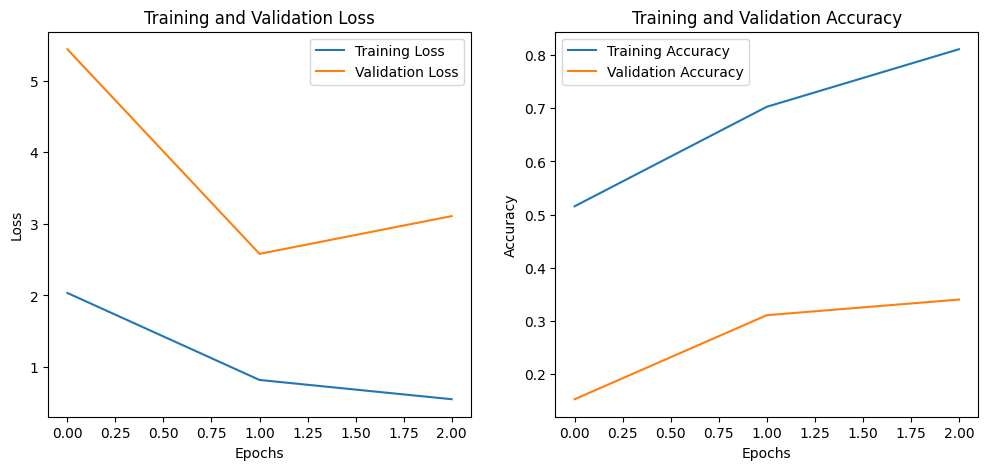

In [9]:
# Plot training and validation loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()

In [10]:
from collections import defaultdict
import torch

# Dictionary to store predictions
tile_predictions = defaultdict(list)

model.eval()  # Set model to evaluation mode
with torch.no_grad():
    for inputs, labels, image_ids in test_loader:  # Adjust as per your DataLoader
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        
        # Store predictions with their corresponding image IDs
        for image_id, pred in zip(image_ids, predicted.cpu().numpy()):
            tile_predictions[image_id].append(pred)

### Classification results for predictions on 549 tile images from 5 TMA

In [11]:
from sklearn.metrics import classification_report

# Lists to store all predictions and true labels
y_pred_tiles = []
y_true_tiles = []

model.eval()  # Set model to evaluation mode
with torch.no_grad():
    for inputs, labels, image_ids in test_loader:  # Adjust as per your DataLoader
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        
        # Store predictions and true labels
        y_pred_tiles.extend(predicted.cpu().numpy())
        y_true_tiles.extend(labels.cpu().numpy())

# Generate the classification report
report = classification_report(y_true_tiles, y_pred_tiles, target_names=list(label_map.keys()))

print(report)

              precision    recall  f1-score   support

        HGSC       0.41      0.93      0.57       100
        LGSC       0.15      0.05      0.07       104
          EC       0.42      0.12      0.18       161
          CC       0.62      0.89      0.73        93
          MC       0.51      0.62      0.56        91

    accuracy                           0.47       549
   macro avg       0.42      0.52      0.42       549
weighted avg       0.42      0.47      0.39       549



### Classification results on 5 TMA images using majority voting from 549 tiles

In [12]:
image_predictions = {}
for image_id, preds in tile_predictions.items():
    # Apply majority voting
    most_common_pred = max(set(preds), key=preds.count)
    image_predictions[image_id] = most_common_pred

In [13]:
inverse_label_map = {v: k for k, v in label_map.items()}

df = pd.read_csv('/root/ubc/train.csv')

# Extract the 'original_image_id' without '.png' for matching
df['original_image_id'] = df['image_id'].astype(str).apply(lambda x: x.split('.')[0])

# Create a dictionary mapping from original_image_id to real label
real_labels_map = pd.Series(df.label.values, index=df.original_image_id).to_dict()

correct_predictions=0
total_images = len(image_predictions)

# Initialize a list to store row data
data = []

for image_id, pred in image_predictions.items():
    real_label = real_labels_map.get(image_id)
    predicted_label = inverse_label_map[pred]
    # Append a dictionary for each row of data
    data.append({
        'Image ID': image_id,
        'Predicted Label': predicted_label,
        'Real Label': real_label
    })
    
    if real_label == predicted_label:
        correct_predictions += 1

# Convert the list of dictionaries into a DataFrame
results_df = pd.DataFrame(data)

# Print the DataFrame
print(results_df)

# Calculate and print accuracy
accuracy = correct_predictions / total_images
print(f"\nOverall Accuracy: {accuracy * 100:.2f}%")

  Image ID Predicted Label Real Label
0    29084              MC       LGSC
1    35565              MC         MC
2    41368            HGSC         EC
3    41586              CC         CC
4    50932            HGSC       HGSC

Overall Accuracy: 60.00%


In [15]:
from sklearn.metrics import classification_report

# Given data
y_true = ['LGSC', 'MC', 'EC', 'CC', 'HGSC']  # Actual labels
y_pred = ['MC', 'MC', 'HGSC', 'CC', 'HGSC']  # Predicted labels

# Generate the classification report
report = classification_report(y_true, y_pred, labels=['HGSC', 'LGSC', 'EC', 'CC', 'MC'], zero_division=0)

print(report)

              precision    recall  f1-score   support

        HGSC       0.50      1.00      0.67         1
        LGSC       0.00      0.00      0.00         1
          EC       0.00      0.00      0.00         1
          CC       1.00      1.00      1.00         1
          MC       0.50      1.00      0.67         1

    accuracy                           0.60         5
   macro avg       0.40      0.60      0.47         5
weighted avg       0.40      0.60      0.47         5

